In [3]:
%matplotlib inline 

from IPython.display import clear_output

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import h5py


# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

# Format plots 
font = {'family' : 'serif',
        #'color'  : 'black',
        'weight' : 'normal',
        'size'   : 16,
        }
fontlabel = {'family' : 'serif',
        #'color'  : 'black',
        'weight' : 'normal',
        'size'   : 16,
        }
from matplotlib.ticker import FormatStrFormatter
plt.rc('font', **font)

In [4]:
from scipy.sparse import csr_matrix
def nufd(x):
    n = len(x)
    h = x[1:]-x[:n-1]
    a0 = -(2*h[0]+h[1])/(h[0]*(h[0]+h[1]))
    ak = -h[1:]/(h[:n-2]*(h[:n-2]+h[1:]))
    an = h[-1]/(h[-2]*(h[-1]+h[-2]))
    b0 = (h[0]+h[1])/(h[0]*h[1]) 
    bk = (h[1:] - h[:n-2])/(h[:n-2]*h[1:])
    bn = -(h[-1]+h[-2])/(h[-1]*h[-2])
    c0 = -h[0]/(h[1]*(h[0]+h[1]))
    ck = h[:n-2]/(h[1:]*(h[:n-2]+h[1:]))
    cn = (2*h[-1]+h[-2])/(h[-1]*(h[-2]+h[-1]))
    val  = np.hstack((a0,ak,an,b0,bk,bn,c0,ck,cn))
    row = np.tile(np.arange(n),3)
    dex = np.hstack((0,np.arange(n-2),n-3))
    col = np.hstack((dex,dex+1,dex+2))
    D = csr_matrix((val,(row,col)),shape=(n,n))
    return D

In [5]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

print(tf.__version__)

2.4.1


In [6]:
folder = "Pulsatile/T30/"
filenameh5 = "Stats-T30-128.03.h5"

with h5py.File(folder+filenameh5, 'r') as hf:
    stats = hf['stats'][:]
    z = hf['z'][:]

nz = 129

nx = 128
ny = 128
nz = 129
run = "03"
number_of_phases = 32 # over half a period
number_of_periods = 1


z_all = np.zeros(nz+2)
z_all[0] = -1.
z_all[-1] = 1.
z_all[1:-1] = np.copy(z)
a_metrics = np.zeros(nz)
c_metrics = np.zeros(nz)
a_metrics[:] = 1. / ((z_all[1:-1] - z_all[0:-2])*(z_all[2:]-z_all[0:-2]))
c_metrics[:] = 1. / ((z_all[2:] - z_all[1:-1])*(z_all[2:]-z_all[0:-2]))
dz = nufd(z_all)


nu = 1./2000

i_mean = 0
i_ms = 1
i_skew = 2
i_flat = 3
nstats = 4

i_u = 0
i_uu = 1
i_vv = 2
i_ww = 3
i_T = 4
i_uw = 5
i_wT = 6
i_dudy = 7
i_eps = 8
i_dTdy = 9
nscalars = 10

In [7]:
stats.shape

(32, 10, 129)

In [8]:
z.shape

(129,)

In [5]:
T = abs(stats[:,i_T,:])
# print(dTdy.shape)
T_vect = [T[i,:] for i in range(len(T))]
T_vect = np.concatenate(T_vect)
print(T_vect)
print(T_vect.shape)

[6.2   6.198 6.195 ... 6.827 6.831 6.833]
(4128,)


In [6]:
eps = stats[:,i_eps,:]

eps_vect = [eps[i,:] for i in range(len(eps))]
eps_vect = np.concatenate(eps_vect)
print(eps_vect)
print(eps_vect.shape)

[0.079 0.076 0.073 ... 0.178 0.185 0.192]
(4128,)


In [7]:
# k = np.zeros((32,nz))
# for i in [i_uu,i_vv,i_ww]:
#     k += stats[:,i,:]
# k /= 2.
# print(k.shape)
# nu_t = 0.09*k**2/stats[:,i_eps,:]
# alpha_t = -stats[:,i_wT,:]/stats[:,i_dTdy,:]
# Prt = nu_t/alpha_t
# print(Prt.shape, z.shape)

(32, 129)
[0.    0.    0.    ... 0.001 0.    0.   ]
0.010356397058621918
(4128,)


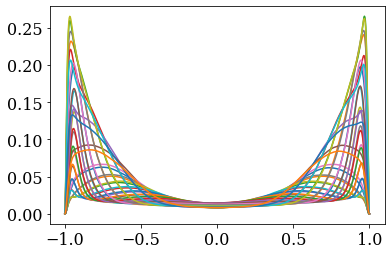

In [8]:
num_phases = 32
k = np.zeros((num_phases,nz))
for iphase in range(num_phases):
    k_ph = np.sum(stats[iphase,i_uu:i_ww+1,:],axis = 0)/2
    k[iphase,:] = np.copy(k_ph)
    plt.plot(z,k_ph)
print(k.shape)

In [ ]:
k_vect = [k[i,:] for i in range(len(k))]
k_vect = np.concatenate(k_vect)
print(k_vect)
print(k_vect[12])
print(k_vect.shape)

In [9]:
# k = np.sum(stats[:,i_uu:i_ww+1,:], axis=0)/2
# k.shape

In [10]:
nu_t = 0.09*k**2/stats[:,i_eps,:]
alpha_t = -stats[:,i_wT,:]/stats[:,i_dTdy,:]
Prt = nu_t/alpha_t
print(Prt.shape)

prt_vect = [Prt[i,:] for i in range(len(Prt))]
prt_vect = np.concatenate(prt_vect)
print(prt_vect)
print(prt_vect.shape)

(32, 129)
[0.025 0.138 0.258 ... 0.323 0.172 0.031]
(4128,)


In [11]:
# phase = 10
# plt.scatter(z, Prt[phase,:])

$$
\nu_t = C_\nu \frac{k^2}{\epsilon}
$$
$$
\frac{\partial \bar{T}}{\partial t} = \frac{\partial}{\partial z} \Big( \alpha + \frac{\nu_t}{Pr_t} \Big) \frac{\partial \bar{T}}{\partial }
$$

In [12]:
# nu_t = -stats[:,i_uw,:]/stats[:,i_dudy]
# alpha_t = -stats[:,i_wT,:]/stats[:,i_dTdy]
# Prt = nu_t/alpha_t
# print(Prt.shape, z.shape)

In [13]:
Prt_disp = pd.DataFrame(Prt.transpose(), index=['z=%.3f' % z[i] for i in range(len(z))], columns = [f'Phase {n}' for n in range(1, 33)])
print(type(z))
Prt_disp.tail()

<class 'numpy.ndarray'>


,Phase 1,Phase 2,Phase 3,Phase 4,Phase 5,Phase 6,Phase 7,Phase 8,Phase 9,Phase 10,...,Phase 23,Phase 24,Phase 25,Phase 26,Phase 27,Phase 28,Phase 29,Phase 30,Phase 31,Phase 32
z=0.996,0.486463,0.949736,2.687892,6.020536,10.092255,14.413536,17.054001,15.249281,10.100369,6.730057,...,17.257095,15.152474,9.264485,5.946616,5.207336,4.532282,3.642784,2.412239,1.368238,0.659191
z=0.997,0.357367,0.702441,2.007514,4.524044,7.585789,10.797726,12.736396,11.261929,7.266623,4.821013,...,12.855702,11.220941,6.699476,4.227702,3.678934,3.226690,2.589448,1.732022,0.994400,0.484444
z=0.998,0.238091,0.471225,1.356410,3.071756,5.158615,7.325972,8.618050,7.548954,4.781400,3.163999,...,8.684465,7.543947,4.418102,2.757711,2.391061,2.108658,1.690547,1.138883,0.659083,0.323024
z=0.999,0.127051,0.253034,0.731090,1.662434,2.802018,3.974686,4.664275,4.053804,2.535694,1.674870,...,4.697042,4.063318,2.343841,1.453468,1.258124,1.113437,0.892396,0.603692,0.350946,0.172460
z=1.000,0.022993,0.046398,0.134676,0.307554,0.517405,0.731237,0.854482,0.737346,0.456814,0.301019,...,0.860985,0.741091,0.421862,0.260335,0.225159,0.199660,0.159993,0.108494,0.063261,0.031140


In [14]:
# z_vect = [z for _ in range(32)]
# z_vect = np.concatenate(z_vect)
# print(z_vect)
# print(z_vect.shape)

### Create Panda DataFrame with vector form of input matrices

In [15]:
prt_pd = pd.DataFrame(
#     {'eps':eps_vect, 'k':k_vect, 'Pr': prt_vect})
    {'eps':eps_vect, 'k':k_vect, 'T':T_vect, 'Pr': prt_vect})
dataset = prt_pd
prt_pd.tail()

,eps,k,dTdy,Pr
4123,0.163328,0.002205,6.797504,0.659191
4124,0.170457,0.001255,6.817246,0.484444
4125,0.177595,0.000602,6.827124,0.323024
4126,0.184857,0.000204,6.831176,0.172460
4127,0.192449,0.000022,6.833142,0.031140


# DNN: Predict Prandtl Number 
... as a function of k, epsilon, and temperature profile

In [16]:
def build_and_compile_model(norm):
    model = keras.Sequential([
        norm,
        layers.Dense(129, activation='relu'),
        layers.Dense(129, activation='relu'),
        layers.Dense(129, activation='relu'),
        
        layers.Dense(1)
    ])
    
    model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
    return model

In [17]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 10])
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)

In [18]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)
print(train_dataset)

           eps         k      dTdy         Pr
1065  0.095319  0.071805  1.129781   4.487105
45    0.048997  0.059908  0.297932   0.376864
1569  0.419107  0.255504  2.291876  10.749572
1280  0.258917  0.025849  3.148608  22.232031
3249  0.275270  0.166188  2.374040  25.731303
...        ...       ...       ...        ...
1911  0.199523  0.138706  1.666301   3.030469
2538  0.017455  0.030298  0.240291   0.370121
74    0.017536  0.028442  0.267668   0.234787
515   0.047632  0.000005  4.042689   0.307554
1309  0.319719  0.163190  2.771638  27.233634

[3302 rows x 4 columns]


In [19]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()
print(train_features)

train_labels = train_features.pop('Pr')
test_labels = test_features.pop('Pr')


           eps         k      dTdy         Pr
1065  0.095319  0.071805  1.129781   4.487105
45    0.048997  0.059908  0.297932   0.376864
1569  0.419107  0.255504  2.291876  10.749572
1280  0.258917  0.025849  3.148608  22.232031
3249  0.275270  0.166188  2.374040  25.731303
...        ...       ...       ...        ...
1911  0.199523  0.138706  1.666301   3.030469
2538  0.017455  0.030298  0.240291   0.370121
74    0.017536  0.028442  0.267668   0.234787
515   0.047632  0.000005  4.042689   0.307554
1309  0.319719  0.163190  2.771638  27.233634

[3302 rows x 4 columns]


#### Normalize Input Layer

In [20]:
normalizer = preprocessing.Normalization()
normalizer.adapt(np.array(train_features))

In [21]:
dnn_model = build_and_compile_model(normalizer)

In [22]:
dnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 3)                 7         
_________________________________________________________________
dense (Dense)                (None, 129)               516       
_________________________________________________________________
dense_1 (Dense)              (None, 129)               16770     
_________________________________________________________________
dense_2 (Dense)              (None, 129)               16770     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 130       
Total params: 34,193
Trainable params: 34,186
Non-trainable params: 7
_________________________________________________________________


In [23]:
%%time
history = dnn_model.fit(
    train_features, train_labels,
    validation_split=0.2,
    verbose=0, epochs=500)

CPU times: user 16min 40s, sys: 16min 26s, total: 33min 6s
Wall time: 4min 19s


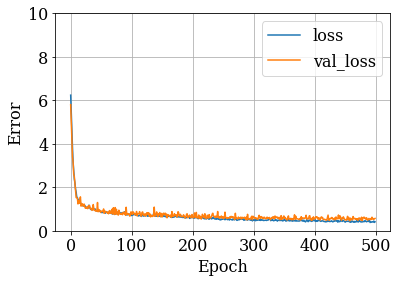

In [24]:
plot_loss(history)

In [25]:
def plot_z(x, y):
    plt.scatter(train_features['z'], train_labels, label='Data')
    plt.plot(x, y, color='k', label='Predictions')
    plt.xlabel('z')
    plt.ylabel('Pr')
    plt.legend()
    plt.ylim([-10, 10])

In [26]:
# print(z[10])
# print(phase_vect[:129])
# print(np.full(shape=129, fill_value=phase, dtype=np.int))

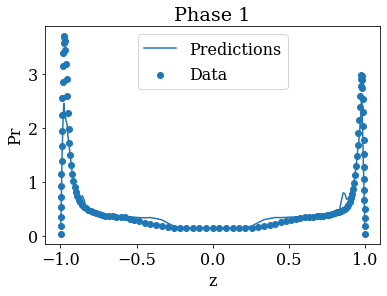

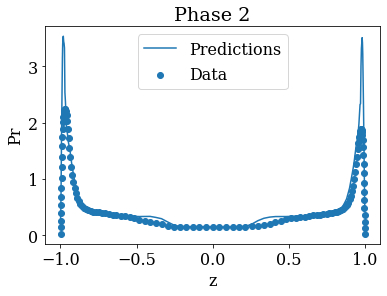

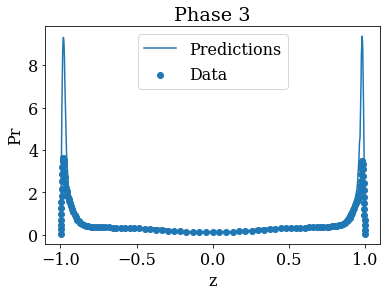

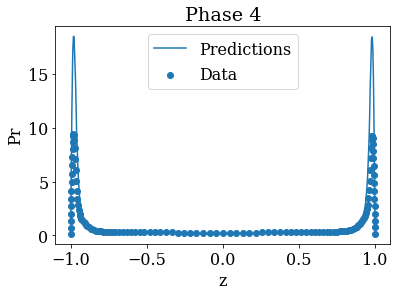

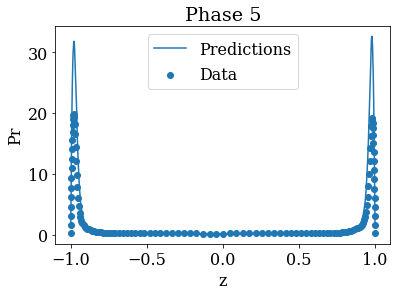

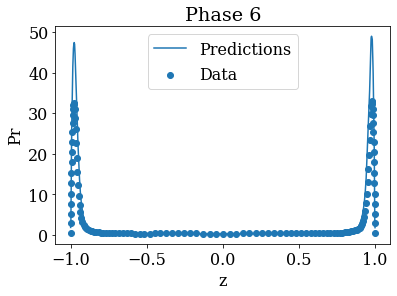

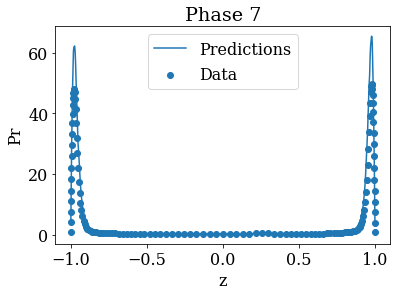

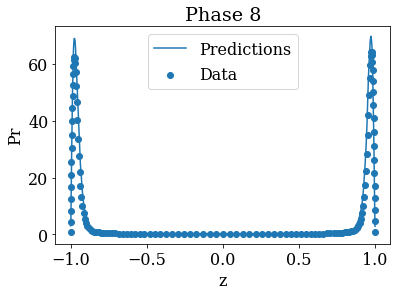

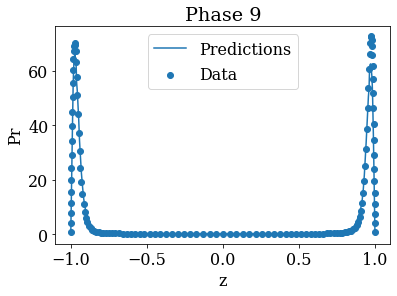

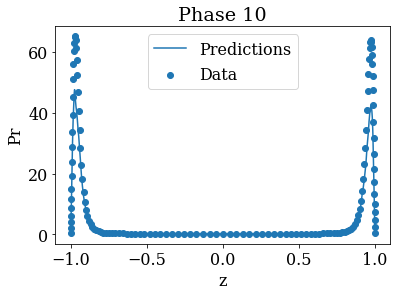

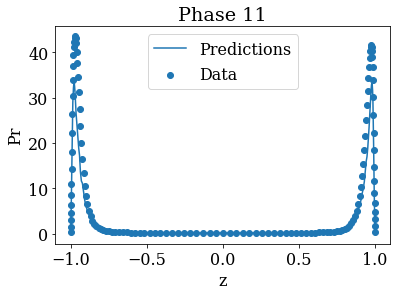

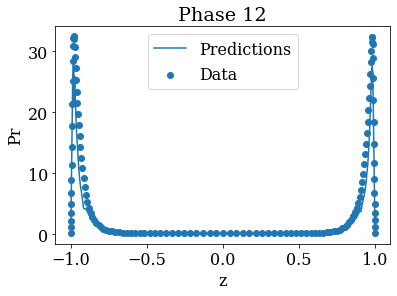

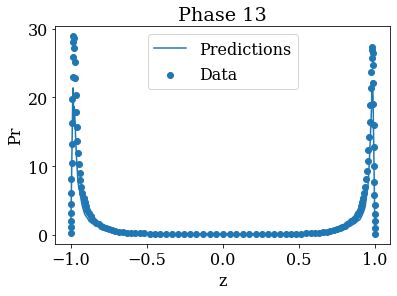

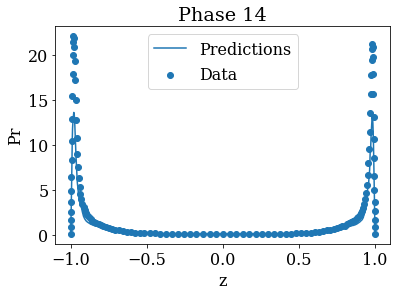

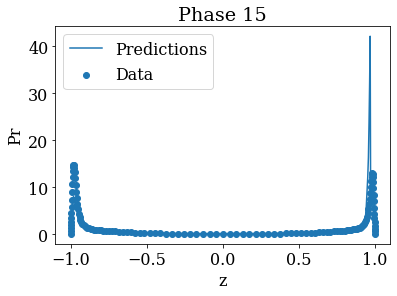

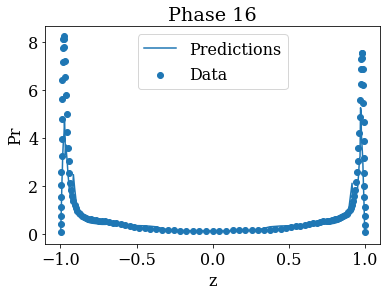

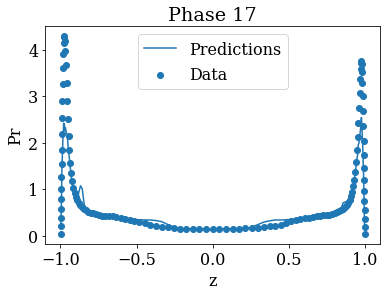

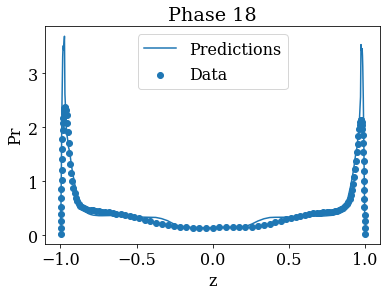

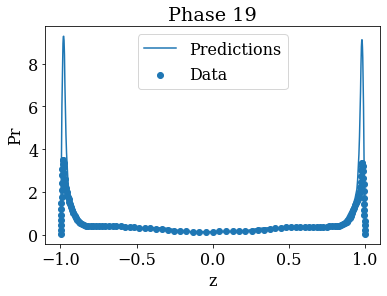

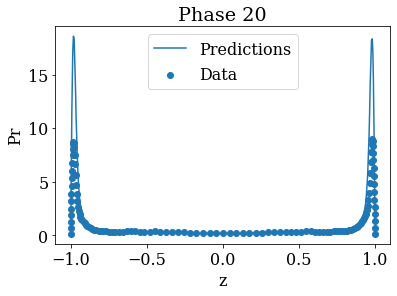

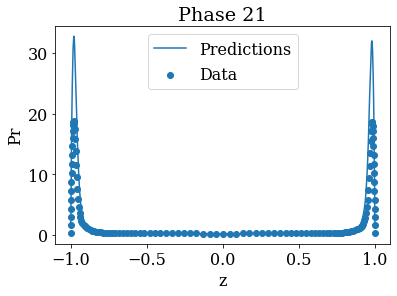

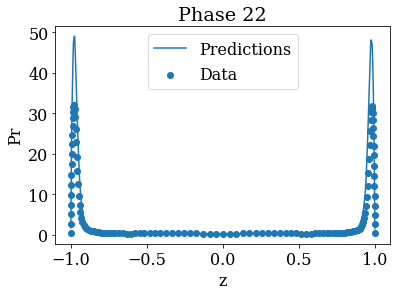

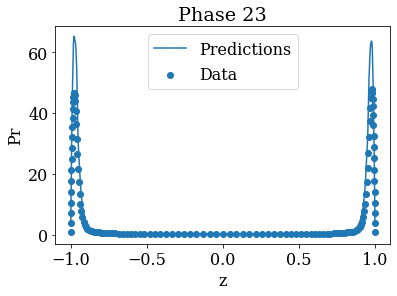

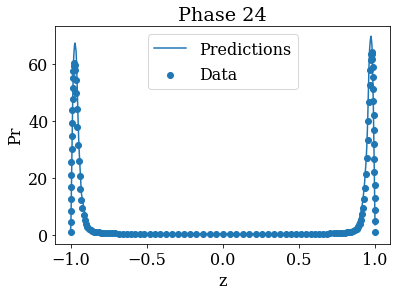

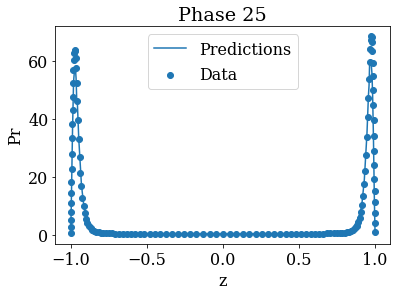

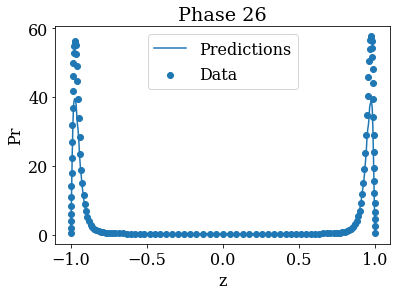

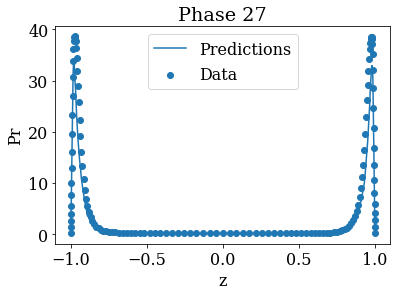

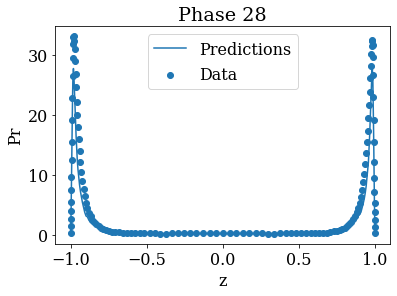

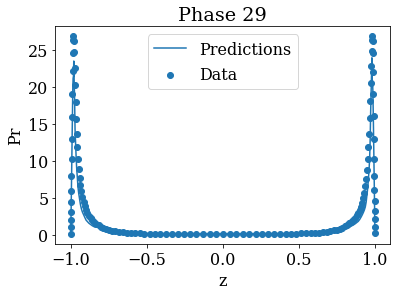

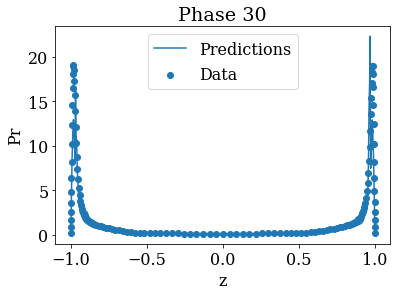

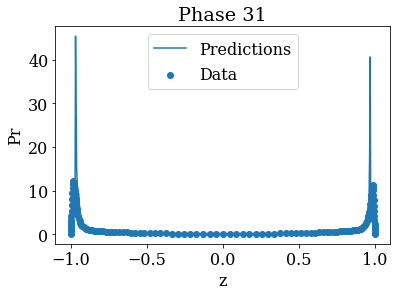

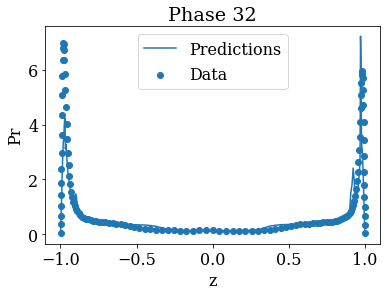

In [27]:
for phase in range(32):
    prediction_input = pd.DataFrame(
#         {'eps':eps[phase,:],'k':k[phase,:]})
        {'eps':eps[phase,:],'k':k[phase,:], 'dTdy':dTdy[phase,:]})

    prediction_output = dnn_model.predict(prediction_input)  # input

    plt.plot(z,prediction_output, label='Predictions')
    plt.scatter(z,Prt[phase-1,:], label='Data')
    plt.ylabel('Pr')
    plt.xlabel('z')
#     plt.xlim([-1,-0.8])
    plt.legend()
    plt.title(f'Phase {phase+1}')
    plt.show()

In [28]:
%%time
prediction_output = dnn_model.predict(prediction_input)

CPU times: user 155 ms, sys: 90.7 ms, total: 245 ms
Wall time: 80 ms


$$
Pr_t = C k^\alpha \bigg\lvert\frac{\partial \bar{T}}{\partial z}\bigg\rvert^\beta \varepsilon^\gamma
$$

$$
Pr_t = f(k,\bigg\lvert\frac{\partial \bar{T}}{\partial z}\bigg\rvert)
$$

In [29]:
# dnn_model.save('dnn_model_v1')